# Advanced_Stock_Price_Prediction

This notebook implements and compares two sequential models for stock price prediction using PyTorch, as per the assignment instructions.

**Models:**
1.  **Model 1:** A standard LSTM (Long Short-Term Memory) network.
2.  **Model 2:** An LSTM network enhanced with an attention mechanism.

**Objective:**
Predict the *relative change* (log returns) of a stock's price and evaluate the models' performance using autoregressive prediction.

## 0. Setup and Imports

First, we import all necessary libraries and set up our environment, including the device (GPU if available) and key parameters.

In [ ]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import time

# Set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Create a 'models' directory if it doesn't already exist
os.makedirs("models", exist_ok=True)

# --- Configuration Parameters ---
STOCK_TICKER = "BTC-USD"    # Example: Bitcoin. You can change this.
START_DATE = "2014-01-01"   # 10 years of data
END_DATE = "2024-11-01"     # Today's date or recent

TRAIN_SPLIT = 0.85          # 85% for training
BASE_WINDOW_SIZE = 50       # Initial window size (50 days)

# --- Model Hyperparameters ---
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 100                # Max epochs (will use early stopping)
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.2
PATIENCE = 10               # For early stopping

Using device: cpu


## 1. Data Acquisition

We use the `yfinance` package to download the daily stock price data for our chosen ticker.

/var/folders/cs/nmjpwj994ysgj_x48mhkn9200000gn/T/ipykernel_16631/785496161.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed


<Figure size 1400x700 with 0 Axes>

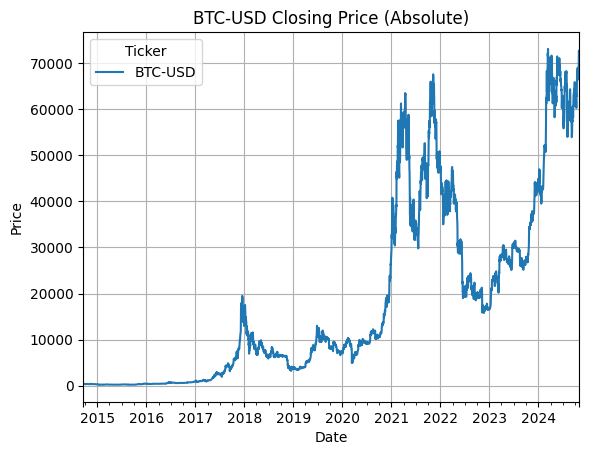

In [2]:
try:
    # Download data
    data = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)
    
    if data.empty:
        print(f"No data found for ticker {STOCK_TICKER}. Please check the ticker or date range.")
    else:
        # We only need the 'Close' price
        prices = data['Close']
        
        # Plot the downloaded data
        plt.figure(figsize=(14, 7))
        prices.plot()
        plt.title(f"{STOCK_TICKER} Closing Price (Absolute)")
        plt.ylabel("Price")
        plt.xlabel("Date")
        plt.grid(True)
        plt.show()

except Exception as e:
    print(f"Error downloading data: {e}")
    print("Please see the 'Appendix: How to Add Data Manually' section at the end of this notebook.")


## 2. Data Preparation

### 2.1. Calculate Relative Values (Log Returns)

As instructed, we will predict relative values instead of absolute prices. We'll use **log returns**, which are defined as $\log(P_t / P_{t-1})$. This transformation stabilizes the variance and makes the time series more stationary.


Original price points: 3698
Log return points: 3697


<Figure size 1400x700 with 0 Axes>

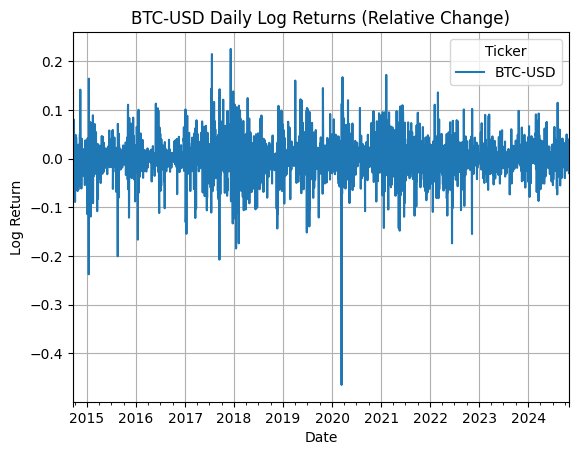

In [3]:
# Calculate log returns
log_returns = np.log(prices / prices.shift(1))

# Drop the first NaN value that results from the shift
log_returns = log_returns.dropna()

# Convert to numpy array for processing
log_returns_np = log_returns.values.astype(np.float32)

print(f"Original price points: {len(prices)}")
print(f"Log return points: {len(log_returns_np)}")

# Plot log returns
plt.figure(figsize=(14, 7))
log_returns.plot()
plt.title(f"{STOCK_TICKER} Daily Log Returns (Relative Change)")
plt.ylabel("Log Return")
plt.xlabel("Date")
plt.grid(True)
plt.show()

### 2.2. Create Sliding Window Dataset

We implement a function to create our dataset based on the sliding window approach.
-   **Input (X):** A sequence of `window_size` consecutive log returns.
-   **Target (y):** The *next* log return immediately following the input sequence.

In [4]:
def create_sliding_windows(data, window_size):
    """
    Creates sliding window sequences (X) and corresponding targets (y).
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        # Input sequence (features)
        X.append(data[i : i + window_size])
        # Target value (the next day's log return)
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Create the dataset
X, y = create_sliding_windows(log_returns_np, BASE_WINDOW_SIZE)

print(f"Shape of X (Inputs): {X.shape}")
print(f"Shape of y (Targets): {y.shape}")

Shape of X (Inputs): (3647, 50, 1)
Shape of y (Targets): (3647, 1)


### 2.3. Split Data and Create DataLoaders

We split the data (85% train, 15% test), convert it to PyTorch tensors, and create `DataLoaders` for batching during training.

In [5]:
# Calculate split index
split_idx = int(len(X) * TRAIN_SPLIT)

# Split the data
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

# Reshape y to be (N, 1) for the loss function
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f"Training set: X shape {X_train.shape}, y shape {y_train.shape}")
print(f"Test set:     X shape {X_test.shape}, y shape {y_test.shape}")

# --- Convert to PyTorch Tensors ---
X_train_t = torch.tensor(X_train).float()
y_train_t = torch.tensor(y_train).float()
X_test_t = torch.tensor(X_test).float()
y_test_t = torch.tensor(y_test).float()

# LSTM expects input shape (N, L, H_in) where N=batch_size, L=seq_len, H_in=input_features
# Our H_in is 1 (just the log return)
if X_train_t.dim() == 2:
    X_train_t = X_train_t.unsqueeze(-1)
if X_test_t.dim() == 2:
    X_test_t = X_test_t.unsqueeze(-1)

print(f"\nTensor shapes (with feature dim):")
print(f"X_train_t shape: {X_train_t.shape}")
print(f"X_test_t shape: {X_test_t.shape}")

# --- Create DataLoaders ---
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Training set: X shape (3099, 50, 1), y shape (3099, 1)
Test set:     X shape (548, 50, 1), y shape (548, 1)

Tensor shapes (with feature dim):
X_train_t shape: torch.Size([3099, 50, 1])
X_test_t shape: torch.Size([548, 50, 1])


## 3. Model Implementation


### Model 1: LSTM Only

This is a standard LSTM model. It consists of an `nn.LSTM` layer followed by an `nn.Linear` layer to produce the final prediction.

**Architecture:**
1.  Input `x` (batch, seq_len, 1) goes into the LSTM.
2.  The LSTM outputs hidden states for all time steps.
3.  We take the output from the *very last time step* (`lstm_out[:, -1, :]`).
4.  This final hidden state is passed to a Linear layer to predict a single value.

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1, dropout=DROPOUT):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,  # Input shape is (batch_size, seq_len, features)
            dropout=dropout    # Dropout between LSTM layers (if num_layers > 1)
        )
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden and cell states (defaults to zeros if not provided)
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Get LSTM outputs
        # lstm_out shape: (batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x) # We don't need the final (h_n, c_n) here
        
        # We only want the output from the last time step
        # lstm_out[:, -1, :] gives (batch_size, hidden_size)
        last_time_step_out = lstm_out[:, -1, :]
        
        # Pass the last output through the linear layer
        prediction = self.fc(last_time_step_out)
        return prediction

### Model 2: LSTM with Attention

This model adds an attention mechanism to the LSTM. Instead of just using the *last* hidden state, the attention mechanism learns to assign different "importance" weights to the hidden states from *all* time steps. It then computes a weighted sum (the "context vector") of all hidden states, which is used for the final prediction.

**Architecture:**
1.  Input `x` goes into the LSTM, producing all hidden states `lstm_out` (batch, seq_len, hidden_size).
2.  **Attention Calculation:**
    a.  Pass `lstm_out` through a linear layer and `tanh` activation to get "energy" scores.
    b.  Pass the energy scores through another linear layer to get raw scores (batch, seq_len, 1).
    c.  Apply `softmax` along the time dimension to get attention weights (batch, seq_len, 1). These weights sum to 1.
3.  **Context Vector:**
    a.  Multiply the weights with the original `lstm_out` (element-wise).
    b.  Sum the results across the time dimension to get a single context vector (batch, hidden_size).
4.  Pass this context vector to the final Linear layer for prediction.

In [7]:
class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1, dropout=DROPOUT):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        # Attention layers
        # This layer learns the 'energy' of each hidden state
        self.attn_W = nn.Linear(hidden_size, hidden_size)
        # This layer learns the 'v' vector to compute the final score
        self.attn_v = nn.Linear(hidden_size, 1, bias=False)
        
        # Final prediction layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # lstm_out: (batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)
        
        # --- Attention Mechanism ---
        # 1. Calculate energy
        # (batch_size, seq_len, hidden_size) -> (batch_size, seq_len, hidden_size)
        energy = torch.tanh(self.attn_W(lstm_out))
        
        # 2. Calculate scores
        # (batch_size, seq_len, hidden_size) -> (batch_size, seq_len, 1)
        scores = self.attn_v(energy)
        
        # 3. Get weights (softmax over time dimension, dim=1)
        # (batch_size, seq_len, 1)
        weights = torch.softmax(scores, dim=1)
        
        # 4. Calculate context vector
        # (batch_size, seq_len, 1) * (batch_size, seq_len, hidden_size) -> (batch_size, seq_len, hidden_size)
        weighted_out = weights * lstm_out
        # Sum across time dimension: (batch_size, hidden_size)
        context = torch.sum(weighted_out, dim=1)
        # ---------------------------
        
        # Final prediction
        prediction = self.fc(context)
        return prediction

## 4. Training the Models


### 4.1. Early Stopping Utility

To prevent overfitting and save time, we'll implement an `EarlyStopping` class. It monitors the validation loss and stops training if it doesn't improve for a specified number of `patience` epochs. It also saves the best model.

In [8]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, verbose=True, path='checkpoint.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.verbose:
                print(f"   ...Val loss improved to {val_loss:.6f}. Saving model to {self.path}...")
            torch.save(model.state_dict(), self.path)
        else:
            self.counter += 1
            if self.verbose:
                print(f"   ...EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


### 4.2. Training Function

This function contains the main training and validation loop. It's reusable for both models.

In [9]:
def train_model(model, train_loader, test_loader, epochs, lr, patience, model_path):
    criterion = nn.MSELoss()  # Mean Squared Error is suitable for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    early_stopper = EarlyStopping(patience=patience, path=model_path, verbose=True)
    
    train_losses = []
    val_losses = []
    
    model.to(DEVICE)
    
    print(f"--- Starting Training for {model_path} ---")
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * X_batch.size(0)
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # --- Validation ---
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_val_loss += loss.item() * X_batch.size(0)
                
        epoch_val_loss = running_val_loss / len(test_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f"Epoch {epoch+1:03}/{epochs:03} | Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}")
        
        # Check early stopping
        early_stopper(epoch_val_loss, model)
        if early_stopper.early_stop:
            print("Early stopping triggered!")
            break
            
    end_time = time.time()
    print(f"--- Training Finished in {end_time - start_time:.2f}s ---")
    
    # Load the best model state
    model.load_state_dict(torch.load(model_path))
    
    return model, train_losses, val_losses

def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True)
    plt.show()

### 4.3. Train Model 1 (LSTM)

--- Starting Training for models/best_lstm_model.pth ---
Epoch 001/100 | Train Loss: 0.002434 | Val Loss: 0.000612
   ...Val loss improved to 0.000612. Saving model to models/best_lstm_model.pth...
Epoch 002/100 | Train Loss: 0.001484 | Val Loss: 0.000607
   ...Val loss improved to 0.000607. Saving model to models/best_lstm_model.pth...
Epoch 003/100 | Train Loss: 0.001493 | Val Loss: 0.000608
   ...EarlyStopping counter: 1 out of 10
Epoch 004/100 | Train Loss: 0.001487 | Val Loss: 0.000630
   ...EarlyStopping counter: 2 out of 10
Epoch 005/100 | Train Loss: 0.001487 | Val Loss: 0.000643
   ...EarlyStopping counter: 3 out of 10
Epoch 006/100 | Train Loss: 0.001514 | Val Loss: 0.000606
   ...Val loss improved to 0.000606. Saving model to models/best_lstm_model.pth...
Epoch 007/100 | Train Loss: 0.001485 | Val Loss: 0.000613
   ...EarlyStopping counter: 1 out of 10
Epoch 008/100 | Train Loss: 0.001482 | Val Loss: 0.000624
   ...EarlyStopping counter: 2 out of 10
Epoch 009/100 | Train Los

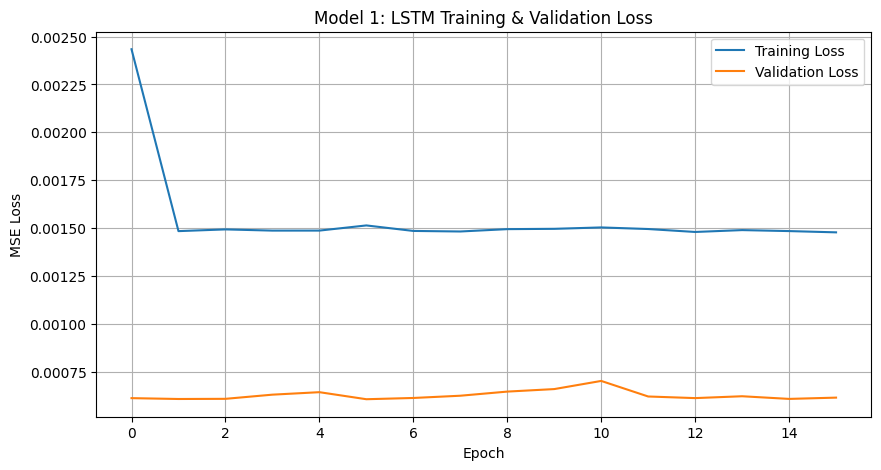

In [10]:
lstm_model = LSTMModel(
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

lstm_model, lstm_train_loss, lstm_val_loss = train_model(
    lstm_model,
    train_loader,
    test_loader,
    EPOCHS,
    LEARNING_RATE,
    PATIENCE,
    'models/best_lstm_model.pth' # Path to save best model
)

plot_losses(lstm_train_loss, lstm_val_loss, "Model 1: LSTM Training & Validation Loss")

### 4.4. Train Model 2 (LSTM + Attention)

We train the attention model under the same conditions (same data, epochs, lr, etc.) for a fair comparison.

--- Starting Training for models/best_attention_model.pth ---
Epoch 001/100 | Train Loss: 0.001649 | Val Loss: 0.000606
   ...Val loss improved to 0.000606. Saving model to models/best_attention_model.pth...
Epoch 002/100 | Train Loss: 0.001513 | Val Loss: 0.000608
   ...EarlyStopping counter: 1 out of 10
Epoch 003/100 | Train Loss: 0.001482 | Val Loss: 0.000606
   ...EarlyStopping counter: 2 out of 10
Epoch 004/100 | Train Loss: 0.001496 | Val Loss: 0.000671
   ...EarlyStopping counter: 3 out of 10
Epoch 005/100 | Train Loss: 0.001483 | Val Loss: 0.000737
   ...EarlyStopping counter: 4 out of 10
Epoch 006/100 | Train Loss: 0.001508 | Val Loss: 0.000607
   ...EarlyStopping counter: 5 out of 10
Epoch 007/100 | Train Loss: 0.001498 | Val Loss: 0.000607
   ...EarlyStopping counter: 6 out of 10
Epoch 008/100 | Train Loss: 0.001474 | Val Loss: 0.000635
   ...EarlyStopping counter: 7 out of 10
Epoch 009/100 | Train Loss: 0.001481 | Val Loss: 0.000606
   ...EarlyStopping counter: 8 out of 10


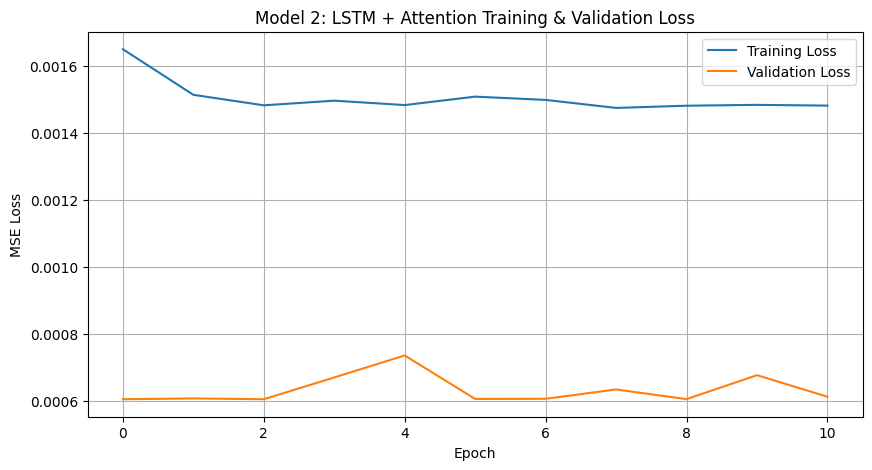

In [17]:
attention_model = LSTMAttentionModel(
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

attention_model, attn_train_loss, attn_val_loss = train_model(
    attention_model,
    train_loader,
    test_loader,
    EPOCHS,
    LEARNING_RATE,
    PATIENCE,
    'models/best_attention_model.pth' # Path to save best model
)

plot_losses(attn_train_loss, attn_val_loss, "Model 2: LSTM + Attention Training & Validation Loss")

## 5. Evaluation and Comparison

### 5.1. Autoregressive Prediction

This is the most critical part of the evaluation. We will simulate a real-world prediction scenario:
1.  Take the **first window** from the test set (`X_test_t[0]`) as the initial input.
2.  Predict the next value (Prediction 1).
3.  Create a **new window** by *dropping* the first value of the initial window and *appending* Prediction 1 to the end.
4.  Use this new window to predict the next value (Prediction 2).
5.  Repeat this process for the entire length of the test set.

This method tests the model's stability, as prediction errors will accumulate (compound) over time.

In [12]:
def autoregressive_predict(model, initial_window_tensor, n_predictions):
    """
    Performs autoregressive prediction.
    `initial_window_tensor` should have shape (window_size, 1).
    """
    model.eval()  # Set model to evaluation mode
    predictions = []
    current_window = initial_window_tensor.clone().to(DEVICE)
    
    with torch.no_grad():
        for _ in range(n_predictions):
            # Input must be (1, window_size, 1) for the model
            input_tensor = current_window.unsqueeze(0)
            
            # Get prediction
            pred = model(input_tensor)
            
            # Store the prediction (as a simple number)
            predictions.append(pred.item())
            
            # Update the window for the next iteration
            # `pred` shape is (1, 1). We need it as (1, 1) to concatenate
            new_entry = pred.cpu() # Shape (1, 1)
            
            # Remove first element and append new prediction
            # current_window[1:] is (window_size-1, 1)
            current_window = torch.cat((current_window[1:], new_entry), dim=0)
            
    return np.array(predictions)

# Get the first window from the test set
# X_test_t shape is (N_test, window_size, 1). We need the first item.
first_test_window = X_test_t[0]

# Number of predictions to make == length of the test set
n_test_predictions = len(y_test_t)

print("Running autoregressive predictions for LSTM model...")
lstm_preds_autoregressive = autoregressive_predict(lstm_model, first_test_window, n_test_predictions)

print("Running autoregressive predictions for Attention model...")
attn_preds_autoregressive = autoregressive_predict(attention_model, first_test_window, n_test_predictions)

# Get actual values for comparison
actuals = y_test_t.cpu().numpy().flatten()

print("Predictions complete.")

Running autoregressive predictions for LSTM model...
Running autoregressive predictions for Attention model...
Predictions complete.


### 5.2. Metrics

We'll use common regression metrics to compare the models:
-   **MSE (Mean Squared Error):** Penalizes large errors heavily.
-   **RMSE (Root Mean Squared Error):** MSE in the original units (log returns).
-   **MAE (Mean Absolute Error):** Average absolute error.

In [13]:
def calculate_metrics(preds, actuals):
    mse = mean_squared_error(actuals, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, preds)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae}

lstm_metrics = calculate_metrics(lstm_preds_autoregressive, actuals)
attn_metrics = calculate_metrics(attn_preds_autoregressive, actuals)

print("--- Autoregressive Performance Metrics ---")
metrics_df = pd.DataFrame([lstm_metrics, attn_metrics], index=['LSTM Model', 'Attention Model'])
display(metrics_df)

--- Autoregressive Performance Metrics ---


,MSE,RMSE,MAE
LSTM Model,0.000606,0.024621,0.017233
Attention Model,0.000606,0.024618,0.017250


### 5.3. Visualization: Predicted vs. Actual Relative Changes

Let's plot the predicted log returns against the actual log returns. Due to the compounding error of autoregression, we expect the predictions to drift over time.

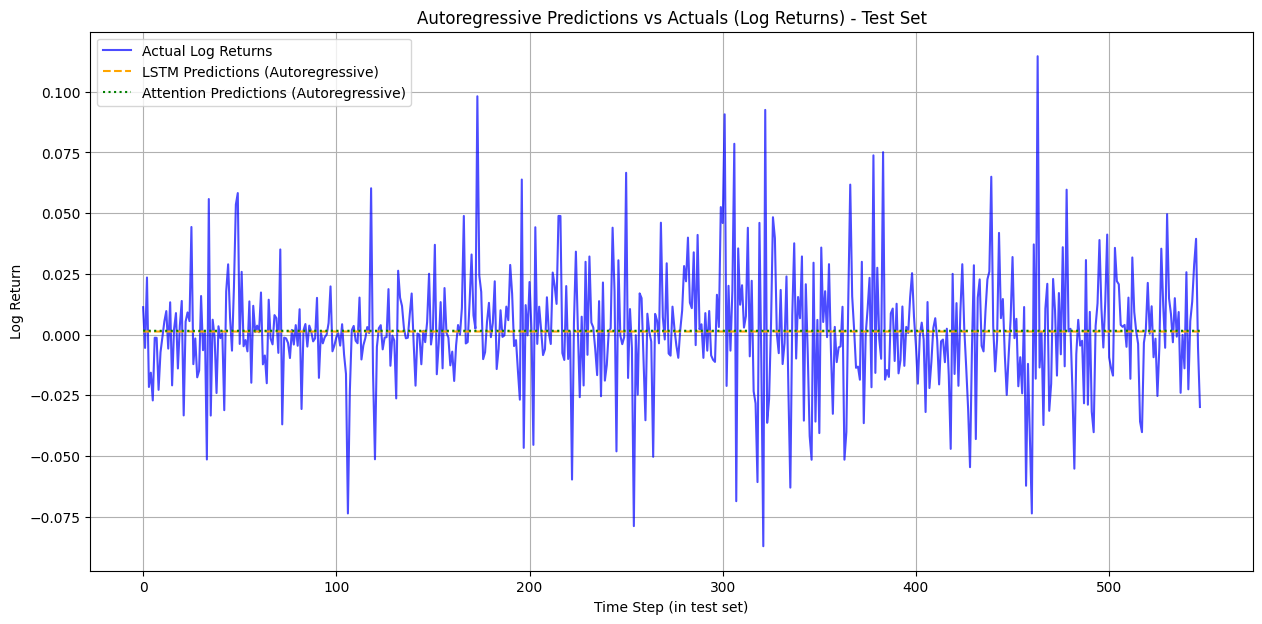

In [14]:
plt.figure(figsize=(15, 7))
plt.plot(actuals, label='Actual Log Returns', color='blue', alpha=0.7)
plt.plot(lstm_preds_autoregressive, label='LSTM Predictions (Autoregressive)', color='orange', linestyle='--')
plt.plot(attn_preds_autoregressive, label='Attention Predictions (Autoregressive)', color='green', linestyle=':')
plt.legend()
plt.title(f'Autoregressive Predictions vs Actuals (Log Returns) - Test Set')
plt.xlabel('Time Step (in test set)')
plt.ylabel('Log Return')
plt.grid(True)
plt.show()

### 5.4. Visualization: Reconstructed Absolute Prices

To make the results more intuitive, we will reconstruct the absolute prices from the predicted log returns.

The formula is: $P_t = P_{t-1} \cdot e^{\text{log\_return}_t}$

We need a starting price, which will be the last *actual* price *before* the test set began.

Reconstruction Start Price (on 2023-05-02): $28680.54
Actual test prices to compare: 548
Predictions made: 548


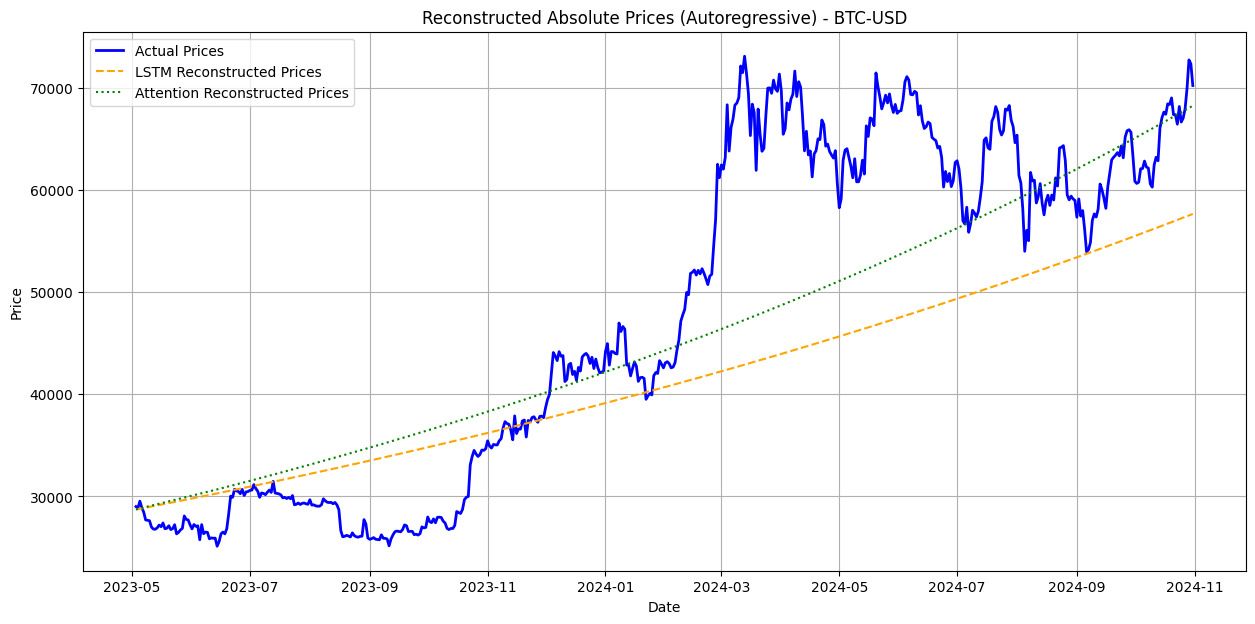

In [15]:
def reconstruct_prices(start_price, log_returns):
    """Converts log returns back to absolute prices."""
    prices = [start_price]
    current_price = start_price
    for log_ret in log_returns:
        current_price = current_price * np.exp(log_ret)
        prices.append(current_price)
    return np.array(prices)

# --- Find the correct start price and actual test prices ---

# `log_returns` is the pd.Series with the DatetimeIndex
# `split_idx` was the split index on `X`
# `y_test[0]` corresponds to `y[split_idx]`
# `y[split_idx]` corresponds to `log_returns_np[split_idx + BASE_WINDOW_SIZE]`
# This corresponds to the pandas Series `log_returns.iloc[split_idx + BASE_WINDOW_SIZE]`
first_test_log_return_index = log_returns.index[split_idx + BASE_WINDOW_SIZE]

# The start price is the price on the day *before* this first test log return
# We find the original 'prices' index location *before* this timestamp
start_price_timestamp = prices.index[prices.index < first_test_log_return_index][-1]
start_price = prices.loc[start_price_timestamp].iloc[0]

# The actual test prices start on `first_test_log_return_index`
actual_test_prices_pd = prices.loc[first_test_log_return_index:]

# Ensure it's the same length as our predictions
actual_test_prices = actual_test_prices_pd.iloc[:len(actuals)].values

print(f"Reconstruction Start Price (on {start_price_timestamp.date()}): ${start_price:.2f}")
print(f"Actual test prices to compare: {len(actual_test_prices)}")
print(f"Predictions made: {len(actuals)}")

# --- Reconstruct prices from predictions ---
lstm_recon_prices = reconstruct_prices(start_price, lstm_preds_autoregressive)
attn_recon_prices = reconstruct_prices(start_price, attn_preds_autoregressive)

# --- Plot reconstructed prices ---
plt.figure(figsize=(15, 7))
test_index = actual_test_prices_pd.iloc[:len(actuals)].index

plt.plot(test_index, actual_test_prices, label='Actual Prices', color='blue', linewidth=2)
plt.plot(test_index, lstm_recon_prices[1:], label='LSTM Reconstructed Prices', color='orange', linestyle='--')
plt.plot(test_index, attn_recon_prices[1:], label='Attention Reconstructed Prices', color='green', linestyle=':')

plt.legend()
plt.title(f'Reconstructed Absolute Prices (Autoregressive) - {STOCK_TICKER}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

## 6. Experimentation with Sliding Window Sizes

Now we'll automate the process to test different window sizes (10, 25, 50, 100). 

**Note:** As per the assignment instructions, we will **only run this for the basic LSTM model** because training the attention model repeatedly is very time-consuming.


==================== RUNNING FOR WINDOW SIZE: 10 ====================
--- Starting Training for models/lstm_model_w10.pth ---
Epoch 001/100 | Train Loss: 0.001672 | Val Loss: 0.000609
   ...Val loss improved to 0.000609. Saving model to models/lstm_model_w10.pth...
Epoch 002/100 | Train Loss: 0.001477 | Val Loss: 0.000611
   ...EarlyStopping counter: 1 out of 10
Epoch 003/100 | Train Loss: 0.001492 | Val Loss: 0.000633
   ...EarlyStopping counter: 2 out of 10
Epoch 004/100 | Train Loss: 0.001484 | Val Loss: 0.000620
   ...EarlyStopping counter: 3 out of 10
Epoch 005/100 | Train Loss: 0.001471 | Val Loss: 0.000648
   ...EarlyStopping counter: 4 out of 10
Epoch 006/100 | Train Loss: 0.001484 | Val Loss: 0.000641
   ...EarlyStopping counter: 5 out of 10
Epoch 007/100 | Train Loss: 0.001490 | Val Loss: 0.000609
   ...EarlyStopping counter: 6 out of 10
Epoch 008/100 | Train Loss: 0.001481 | Val Loss: 0.000621
   ...EarlyStopping counter: 7 out of 10
Epoch 009/100 | Train Loss: 0.001485 | V

,MSE,RMSE,MAE
window_size,,,
10,0.000606,0.024614,0.017284
25,0.000607,0.024633,0.017289
50,0.000606,0.024618,0.017249
100,0.000611,0.024722,0.017275


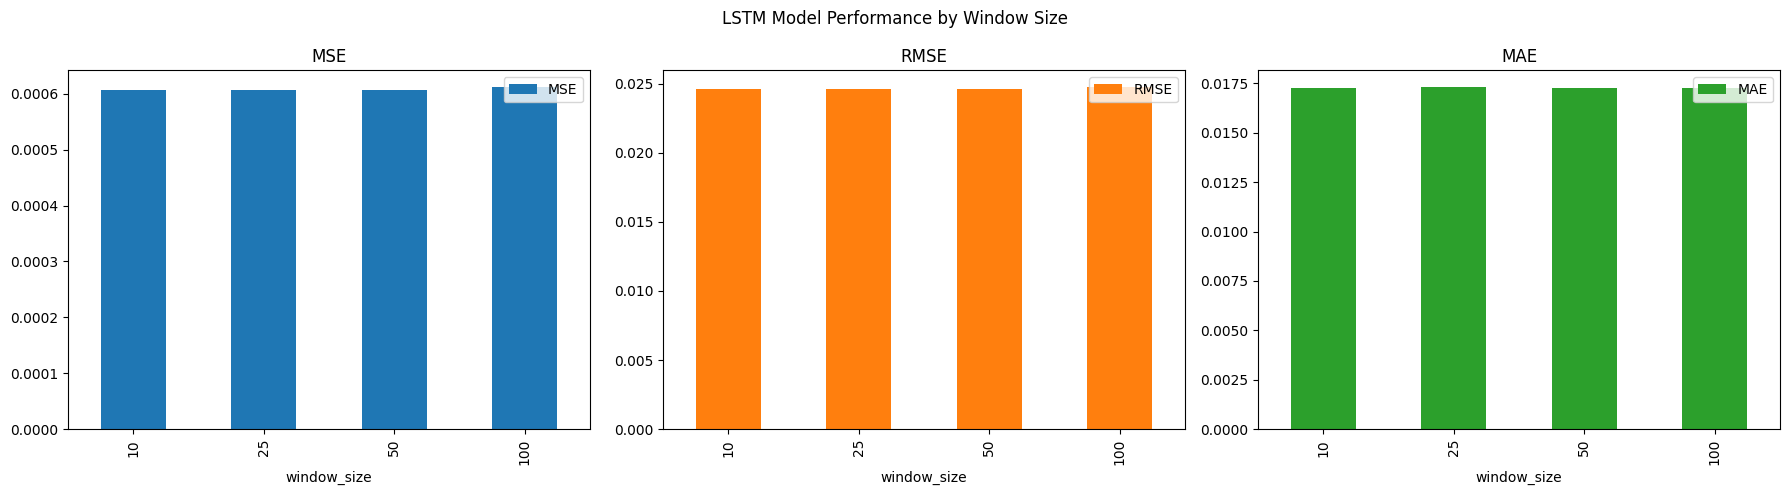

In [16]:
def run_window_experiment(window_size, full_log_returns_data):
    """A complete pipeline to train and evaluate an LSTM model for a given window size."""
    print(f"\n{'='*20} RUNNING FOR WINDOW SIZE: {window_size} {'='*20}")
    
    # 1. Data Prep
    X, y = create_sliding_windows(full_log_returns_data, window_size)
    if len(X) == 0:
        print("Not enough data to create windows. Skipping.")
        return None
    
    split_idx = int(len(X) * TRAIN_SPLIT)
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_test, y_test = X[split_idx:], y[split_idx:]
    
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    if len(X_test) == 0:
        print("Test set is empty for this window size. Skipping.")
        return None
        
    X_train_t = torch.tensor(X_train).float()
    y_train_t = torch.tensor(y_train).float()
    X_test_t = torch.tensor(X_test).float()
    y_test_t = torch.tensor(y_test).float()

    # Add the feature dimension *only if* it's not already there
    if X_train_t.dim() == 2:
        X_train_t = X_train_t.unsqueeze(-1)
    if X_test_t.dim() == 2:
        X_test_t = X_test_t.unsqueeze(-1)
    
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_dataset = TensorDataset(X_test_t, y_test_t)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # 2. Model Training
    model = LSTMModel(
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT
    ).to(DEVICE)
    
    model, _, _ = train_model(
        model,
        train_loader,
        test_loader,
        EPOCHS,
        LEARNING_RATE,
        PATIENCE,
        f'models/lstm_model_w{window_size}.pth'
    )
    
    # 3. Autoregressive Evaluation
    first_test_window = X_test_t[0]
    n_test_predictions = len(y_test_t)
    preds = autoregressive_predict(model, first_test_window, n_test_predictions)
    actuals = y_test_t.cpu().numpy().flatten()
    
    # 4. Calculate Metrics
    metrics = calculate_metrics(preds, actuals)
    metrics['window_size'] = window_size
    
    print(f"--- Metrics for window {window_size}: {metrics} ---")
    return metrics

# --- Run the Experiments ---
window_sizes = [10, 25, 50, 100]
experiment_results = []

for ws in window_sizes:
    result = run_window_experiment(ws, log_returns_np)
    if result:
        experiment_results.append(result)

# --- Compare Results ---
print("\n\n{'='*20} FINAL WINDOW SIZE COMPARISON {'='*20}")
results_df = pd.DataFrame(experiment_results).set_index('window_size')
display(results_df)

# Plot the results
results_df.plot(kind='bar', subplots=True, layout=(1, 3), figsize=(18, 5), title="LSTM Model Performance by Window Size")
plt.tight_layout()
plt.show()

# Discussion